# 使用档案模式的聊天机器人 

## 回顾

我们介绍了 [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)，作为保存与检索长期记忆的方式。

我们构建了一个同时具备 `短期记忆（线程内）` 与 `长期记忆（跨线程）` 的简单聊天机器人。

它会在用户对话的[“热路径”](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories)里保存长期的[语义记忆](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)，即关于用户的事实。

## 目标

之前的机器人把记忆以字符串保存。但在实践中，我们往往希望记忆具备结构化信息。
 
例如，记忆可以是[单个、持续更新的模式](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)。
 
在这个示例中，我们希望它是一个用户档案。
 
我们将扩展聊天机器人，把语义记忆保存到单一的[用户档案](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)中。

同时，我们会介绍 [Trustcall](https://github.com/hinthornw/trustcall) 这个库，用来往该模式中写入新的信息。


In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
import os, getpass


def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")

    # Set the environment variable for the current process
    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 定义用户档案模式

Python 支持多种[结构化数据](https://python.langchain.com/docs/concepts/structured_outputs/#schema-definition)的表示方式，例如 TypedDict、字典、JSON 以及 [Pydantic](https://docs.pydantic.dev/latest/)。

我们先用 TypedDict 来定义一个用户档案模式。


In [3]:
from typing import TypedDict, List


class UserProfile(TypedDict):
    """User profile schema with typed fields"""

    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## 将模式写入存储

[LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 接受任意 Python 字典作为 `value`。


In [4]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"],
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

我们使用 [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) 方法，把 TypedDict 保存到存储中。


In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

我们通过 [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) 根据命名空间检索存储中的对象。


In [6]:
# Search
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'created_at': '2025-09-28T16:43:03.668902+00:00', 'updated_at': '2025-09-28T16:43:03.668908+00:00', 'score': None}


我们也可以使用 [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) 通过命名空间和键获取特定对象。


In [7]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

## 使用档案模式的聊天机器人

现在我们已经知道如何指定记忆的模式并把它保存到存储中。

那么如何生成符合该模式的记忆呢？

在聊天机器人中，我们希望[从用户对话中生成记忆](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)。

这就需要用到[结构化输出](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage)的概念。

LangChain 的[聊天模型](https://python.langchain.com/docs/concepts/chat_models/)接口提供了 [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 方法，用来强制输出遵循某个模式。

当我们需要确保输出符合某个模式时，这个方法非常实用，并且它会替我们解析结果。


In [8]:
# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

让我们把刚才定义的 `UserProfile` 模式传给 `with_structured_output`。

然后，我们用一组[消息](https://python.langchain.com/docs/concepts/messages/)调用聊天模型，就能得到符合模式的结构化输出。


In [9]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage

# from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatTongyi

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen-plus", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke(
    [HumanMessage("My name is Lance, I like to bike.")]
)
structured_output

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


{'user_name': 'Lance', 'interests': ['bike']}

现在把这些能力整合到聊天机器人里。

这只需要对 `write_memory` 函数做少量调整。

我们使用上面定义的 `model_with_structure`，生成符合模式的档案。


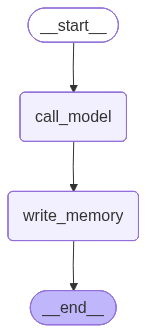

In [10]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
# used in  `call_model`
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
# used in `write_memory`
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke(
        [SystemMessage(content=system_msg)] + state["messages"]
    )

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [
    HumanMessage(
        content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries."
    )
]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hi Lance! It’s great to meet you. San Francisco has some amazing spots for both biking and bakeries—have you got a favorite route or pastry shop yet? I’d love to hear about your adventures! 🚴‍♂️🥐


来看一下存储中的记忆。

可以看到这条记忆是一个与模式一致的字典。


In [12]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'bakeries']}

## 在什么情况下会失败？

[`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 很有用，但如果模式更复杂会怎样呢？

这里有一个[更复杂的模式](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)，我们会在下文测试。

它是一个描述用户沟通偏好与“信任跌倒”场景的 [Pydantic](https://docs.pydantic.dev/latest/) 模型。


In [13]:
from typing import List, Optional


class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str


class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None


class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None


class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None


class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None


class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore


class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences


class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

我们尝试用 `with_structured_output` 方法提取该模式。


In [14]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(
        f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>"""
    )
except ValidationError as e:
    print(e)

如果直接提取复杂模式，即便使用像 `gpt-4o` 这种高能力模型，也很容易失败。


## Trustcall：创建与更新档案模式

可见，处理模式并不轻松。

复杂模式难以抽取。

即便是简单模式，想要更新时也会遇到挑战。

回想上面的聊天机器人。

每次保存新记忆时，我们都需要从零生成整个档案模式。

这既低效（如果模式信息很多会浪费大量 token），也可能导致信息丢失。

解决上述问题正是 [TrustCall](https://github.com/hinthornw/trustcall) 的初心！

它是 LangChain 团队的 [Will Fu-Hinthorn](https://github.com/hinthornw) 开源的 JSON 模式更新库。

这些记忆相关的痛点直接促成了该工具。

我们先对一个[消息列表](https://python.langchain.com/docs/concepts/messages/)演示 TrustCall 的基础抽取。


In [15]:
# Conversation
conversation = [
    HumanMessage(content="Hi, I'm Lance."),
    AIMessage(content="Nice to meet you, Lance."),
    HumanMessage(content="I really like biking around San Francisco."),
]

我们调用 `create_extractor`，把模型和模式作为[工具](https://python.langchain.com/docs/concepts/tools/)传入。

在 TrustCall 中，我们可以用多种方式提供模式。

例如，直接传入 JSON 对象 / Python 字典或 Pydantic 模型。

在底层，TrustCall 会使用[工具调用](https://python.langchain.com/docs/concepts/tool_calling/)从输入的[消息](https://python.langchain.com/docs/concepts/messages/)中产出[结构化输出](https://python.langchain.com/docs/concepts/structured_outputs/)。

如果想强制 TrustCall 产生[结构化输出](https://python.langchain.com/docs/concepts/structured_outputs/)，可以在 `tool_choice` 参数中指明模式名称。

随后，我们对上述对话调用抽取器。


In [16]:
from trustcall import create_extractor


# Schema
class UserProfile(BaseModel):
    """User profile schema with typed fields"""

    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")


# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen-plus", temperature=0)

# Create the extractor
# trustcall_extractor = create_extractor(
#     model, tools=[UserProfile], tool_choice="UserProfile"
# )
trustcall_extractor = create_extractor(model, tools=[UserProfile], tool_choice="auto")

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=system_msg)] + conversation}
)

调用抽取器后，我们会得到：

* `messages`：包含工具调用的 `AIMessage` 列表
* `responses`：已经解析、符合模式的工具调用结果
* `response_metadata`：当更新已有工具调用时会用到，告知每个返回结果对应的原对象


In [17]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_e77f4e6a791b453c8cc4a2)
 Call ID: call_e77f4e6a791b453c8cc4a2
  Args:
    user_name: Lance
    interests: ['biking around San Francisco']


In [18]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking around San Francisco'])]

In [19]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking around San Francisco']}

In [20]:
result["response_metadata"]

[{'id': 'call_e77f4e6a791b453c8cc4a2'}]

来看看 TrustCall 如何用于*更新*档案。

在更新场景下，TrustCall 会接收一组消息和现有的模式。

核心想法是让模型只生成一个 [JSON Patch](https://jsonpatch.com/)，从而只更新相关部分。

相比于直接重写整个模式，这种方式更不易出错。

同时也更高效，因为模型只需生成发生变化的片段。

我们可以先把现有模式保存成字典。

通过 `model_dump()` 可以把 Pydantic 实例序列化为字典。

然后，我们把它和模式名称 `UserProfile` 一起传入 `"existing"` 参数。


In [21]:
# Update the conversation
updated_conversation = [
    HumanMessage(content="Hi, I'm Lance."),
    AIMessage(content="Nice to meet you, Lance."),
    HumanMessage(content="I really like biking around San Francisco."),
    AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
    HumanMessage(content="I really like to go to a bakery after biking."),
]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke(
    {"messages": [SystemMessage(content=system_msg)] + updated_conversation},
    {"existing": {"UserProfile": schema[0].model_dump()}},  # 与上面的不同之处
)

In [22]:
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_fdd36146d35a4c15b591bd)
 Call ID: call_fdd36146d35a4c15b591bd
  Args:
    user_name: Lance
    interests: ['biking', 'bakeries']


In [23]:
result["response_metadata"]

[{'id': 'call_fdd36146d35a4c15b591bd'}]

In [24]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Lance', 'interests': ['biking', 'bakeries']}

LangSmith 追踪：

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

接着，我们也来测试一下上面那个[复杂模式](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema)。


In [25]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    # tool_choice="TelegramAndTrustFallPreferences",
    tool_choice="auto",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# # Extract the preferences
# result["responses"][0]

5 validation errors for TelegramAndTrustFallPreferences
pertinent_user_preferences.communication_preferences.telegram
  Input should be a valid dictionary or instance of TelegramPreferences [type=model_type, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
pertinent_user_preferences.communication_preferences.morse_code
  Input should be a valid dictionary or instance of MorseCode [type=model_type, input_value=True, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
pertinent_user_preferences.communication_preferences.semaphore
  Input should be a valid dictionary or instance of Semaphore [type=model_type, input_value=False, input_type=bool]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type
pertinent_user_preferences.trust_fall_preferences.preferred_fall_height.0
  Input should be a valid dictionary or instance of OutputFormat [type=model_type, in

In [26]:
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_98f3bd8edcd74d5eb1e2ad', 'type': 'function', 'function': {'name': 'TelegramAndTrustFallPreferences', 'arguments': '{"pertinent_user_preferences": {"communication_preferences": {"telegram": true, "morse_code": true, "semaphore": false}, "trust_fall_preferences": {"preferred_fall_height": ["higher"], "preferred_catching_technique": ["diamond formation"], "trust_level": null}, "output_format": {"preference": "structured", "sentence_preference_revealed": "Tell him I\'m ready for a higher fall, and I prefer the diamond formation for catching."}}}'}}]}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': '78193993-9705-4887-911d-1d0e518a066f', 'token_usage': {'input_tokens': 1369, 'output_tokens': 117, 'total_tokens': 1486, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--098a1be5-35a0-49f9-8f84-ddc449f7065e-0', tool_calls=[{'name': 'TelegramAndTrustF

追踪：

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

更多示例可以观看[这段总览视频](https://www.youtube.com/watch?v=-H4s0jQi-QY)。


## 可以更新档案模式的聊天机器人

现在，我们把 TrustCall 引入聊天机器人，实现记忆档案的创建与更新。


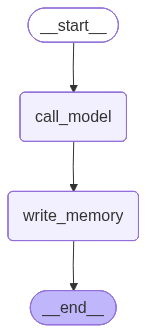

In [27]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
# model = ChatOpenAI(model="gpt-4o", temperature=0)
model = ChatTongyi(model="qwen-plus", temperature=0)


# Schema
class UserProfile(BaseModel):
    """Profile of a user"""

    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")


# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    # tool_choice="UserProfile",  # Enforces use of the UserProfile tool
    # tool_choice="auto",
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = (
        {"UserProfile": existing_memory.value} if existing_memory else None
    )
    print(existing_profile)

    # Invoke the extractor
    ###################### new #####################
    # result = trustcall_extractor.invoke(
    #     {
    #         "messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]
    #         + state["messages"],
    #         "existing": existing_profile,
    #     }
    # )
    result = trustcall_extractor.invoke(
        {
            "messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]
            + state["messages"]
        },
        {
            "existing": existing_profile,
        },
    )
    print(result)

    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()
    ###################### new #####################

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)


# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [28]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! Nice to meet you. How can I assist you today?
None
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_e4bd9081841440f0a806d1', 'type': 'function', 'function': {'name': 'UserProfile', 'arguments': '{"user_name": "Lance", "user_location": "", "interests": []}'}}]}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_id': 'e3d3d713-ee52-4386-ba4b-99a15a7f8bdd', 'token_usage': {'input_tokens': 283, 'output_tokens': 31, 'total_tokens': 314, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--bdf9af92-42aa-4d5b-9084-6a55dc03c641-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Lance', 'user_location': '', 'interests': []}, 'id': 'call_e4bd9081841440f0a806d1', 'type': 'tool_call'}])], 'responses': [UserPr

In [29]:
# User input
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

Hey Lance! That’s awesome—San Francisco has some incredible biking routes with amazing views. Whether you're cruising across the Golden Gate Bridge, riding through Golden Gate Park, or tackling the hills downtown (which I’ve got to assume means you’re in great shape!), there’s so much to explore. Do you have a favorite route or time of day to ride? 🚴‍♂️🌉
{'UserProfile': {'user_name': 'Lance', 'user_location': '', 'interests': []}}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_e893a928fc1648db9104ae', 'type': 'function', 'function': {'name': 'UserProfile', 'arguments': '{"user_name": "Lance", "user_location": "San Francisco", "interests": ["biking"]}'}}]}, response_metadata={'model_name': 'qwen-plus', 'finish_reason': 'tool_calls', 'request_i

In [30]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'created_at': '2025-09-28T16:43:45.014569+00:00',
 'updated_at': '2025-09-28T16:43:45.014572+00:00'}

In [31]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance',
 'user_location': 'San Francisco',
 'interests': ['biking']}

In [32]:
# User input
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

That’s the perfect pairing, Lance—biking around San Francisco and rewarding yourself with a fresh pastry from one of the city’s amazing bakeries! After a ride through the Presidio or up Twin Peaks, there’s nothing better than stopping at a cozy spot for a warm croissant or a slice of sourdough. 

Have you been to **Tartine** in the Mission? It’s a biker favorite—great coffee, legendary morning buns. Or **Arsicault Bakery** in the Richmond? Their kouign-amann is basically a carb masterpiece. If you're biking near North Beach, **Sister’s Bakehouse** has that old-school charm and killer almond croissants.

Want me to map out a sweet (literally) bakery bike route sometime? 🥐🚴‍♂️
{'UserProfile': {'user_name': 'Lance', 'user_location': 'San Francisco', 'interests': ['biking']}}
{'messages': [AIMessag

在新线程中继续对话。


In [33]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Hey Lance! Since you're in San Francisco and love biking, I’ve got some great bakery recommendations that are not only delicious but also fun to ride to. Here are a few local favorites:

1. **Tartine Bakery (Mission District)** – A must-visit. Their morning buns and country bread are legendary. It’s a short, scenic bike ride from most parts of the city, and there’s often outdoor seating where you can enjoy your treat post-ride.

2. **B. Patisserie (Nob Hill/CVille)** – Famous for their kouign-amann and beautiful viennoiserie. The croissants here are flaky perfection. It’s a bit hilly getting there, but totally worth it for the views and pastries.

3. **Arsicault Bakery (Sunset & Arguello)** – Voted one of the best croissant spots in the U.S. The buttery, airy croissants are unreal. A lo

追踪：

https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)
